# Graph Neural Network Implementation

In [970]:
%matplotlib inline
from __future__ import annotations
import random
import enum
from dataclasses import dataclass
from typing import Any, Iterable
import torch
import torch.nn as nn
import numpy as np
from numpy.random import RandomState
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
import networkx as nx

# Fixed random seed

In [971]:
random.seed(0)
random_state: RandomState = RandomState(0)

# Constant

In [972]:
@enum.unique
class Mode(enum.StrEnum):
    TRAIN: str = enum.auto()
    TEST: str = enum.auto()

device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
torch_int: torch.dtype = torch.int16
torch_float: torch.dtype = torch.float32

# Definition of Graph

In [973]:
class Graph(nx.Graph):
    random_state: RandomState
    pos: Any
    label_shape: torch.Size
    def __init__(self, graph: nx.Graph | None = None, random_state: RandomState | None = None) -> None:
        super(Graph, self).__init__(incoming_graph_data=graph)
        self.random_state = random_state
        self.pos = nx.random_layout(self, seed=self.random_state)
        self.label_shape = torch.Size((1, len(self.nodes)))

    def subgraph(self, nodes: ArrayLike | Iterable) -> Graph:
        sub_graph: Graph = Graph(super(Graph, self).subgraph(nodes), self.random_state)
        sub_graph.label_shape = self.label_shape
        return sub_graph

    def label(self, n: int) -> torch.Tensor:
        label: torch.Tensor = torch.zeros(self.label_shape, dtype=torch_float, device=device, requires_grad=False)
        label[:, n] = 1
        label.requires_grad = True
        return label

    def update_pos(self, random_state: RandomState | None = None) -> None:
        if isinstance(random_state, RandomState):
            self.random_state = random_state
        self.pos = nx.random_layout(self, seed=self.random_state)

    def show(self, figsize: tuple[float, float] | None = None) -> None:
        plt.figure(figsize=figsize)
        nx.draw_networkx(self, self.pos)
        plt.show()

# Definition of GNN

In [ ]:
class Phi_w(nn.Module): # Equation (13)
    l_N: int
    s: int
    l_E: int
    layers: nn.Sequential
    def __init__(self, l_N: int, s: int, l_E: int = 0, *args, **kwargs) -> None:
        super(Rho_w, self).__init__(*args, **kwargs)
        self.l_N = l_N
        self.s = s
        self.l_E = l_E
        self.layers = nn.Sequential(
            nn.Linear(2*self.l_N+self.l_E, self.s**2, bias=True, device=device, dtype=torch_float)
        )

    def forward(self, l_n: torch.Tensor, l_u: torch.Tensor, l_e: torch.Tensor | None = None) -> torch.Tensor:
        if l_e is None:
            l: torch.Tensor = torch.vstack((l_n, l_u))
        else:
            l: torch.Tensor = torch.vstack((l_n, l_e, l_u))
        return self.layers(l)

class Rho_w(nn.Module): # Equation (14)
    l_N: int
    s: int
    layers: nn.Sequential
    def __init__(self, l_N: int, s: int, *args, **kwargs) -> None:
        super(Rho_w, self).__init__(*args, **kwargs)
        self.l_N = l_N
        self.s = s
        self.layers = nn.Sequential(
            nn.Linear(self.l_N, self.s, bias=True, device=device, dtype=torch_float)
        )

    def forward(self, l_n: torch.Tensor) -> torch.Tensor:
        return self.layers(l_n)

class H_w(nn.Module): # Equation(12)
    l_N: int
    s: int 
    l_E: int
    mu: float
    phi_w: Phi_w
    rho_w: Rho_w 
    def __init__(self, l_N: int, s: int, l_E: int = 0, mu: float = 1.0, *args, **kwargs) -> None:
        super(H_w, self).__init__(*args, **kwargs)
        self.l_N = l_N
        self.s = s
        self.l_E = l_E
        self.mu = mu
        self.phi = Phi_w(self.l_N, self.s, self.l_E)
        self.rho = Rho_w(self.l_N, self.s)

    def forward(self, l_n: torch.Tensor, x_u: torch.Tensor, l_u: torch.Tensor, u_degree: int, l_e: torch.Tensor | None = None):
        weight_vec = self.phi(l_n, l_u, l_e)
        weight = weight_vec.reshape((self.s, self.s))
        weight = (self.mu / (self.s * u_degree)) * weight
        bias = self.rho(l_n)
        out = weight@x_u + bias
        return out

# f_w, 1つのnodeについて
class F_w(nn.Module):
    in_features: int
    out_features: int

    def __init__(self, l_N: int, s: int, l_E:int, *args, **kwargs) -> None:
        super(F_w, self).__init__(*args, **kwargs)
        self.h_unit = H_w(l_N, s, l_E)

    def forward(self, xs: list[torch.Tensor], G: Graph, n: int) -> None:
        out = 0
        
        for u in G.adj[n]:
            out += self.h_unit(G.nodes[n], xs[u], G.nodes[u], G.degree[u], G.edges[n, u])
        return out



"""
F_w(x,l,G)
x: states (state_dim*n_node)
l: labels (n_node*1)
G: graph
"""
class RNNF(nn.Module):
    def __init__(self, l_N: int, s: int, l_E:int, epsilon: float = 1.0e-2, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.f_unit = F_w(l_N, s, l_E)
        self.epsilon = epsilon
        self.s = s

    def forward(self, xs, G):
        x_tmp = xs
        while True:
            x_next = []
            for n in G.nodes:
                x_next.append(self.f_unit(xs, G, n))
            x_diff_list = [torch.abs(x_tmp[i] - x_next[i]) for i in range(len(xs))]
            error = 0
            for x_diff in x_diff_list:
                error += x_diff

            if error <= self.epsilon:
                break
            
            x_tmp = x_next
        
        return x_tmp

class G_w(nn.Module):
    in_features: int
    out_features: int

    def __init__(self, s:int, l_N:int, m:int, *args, **kwargs) -> None:
        super(G_w, self).__init__(*args, **kwargs)
        self.linear = nn.Linear(s+l_N, m)

    def forward(self, xs: list[torch.Tensor], G: Graph, n: int) -> None:
        out = self.linear(torch.vstack([xs[n], G.nodes[n]]))
        return out


# NOT a torch module
class GNN:
    in_features: int
    out_features: int

    def __init__(self, s:int, l_N:int, l_E:int, m:int, *args, **kwargs) -> None:
        super(GNN, self).__init__(*args, **kwargs)
        self.F_w = RNNF(l_N, s, l_E)
        self.G_w = G_w(s, l_N, m)
        self.s = s

    def __call__(self, *args, **kwds):
        return self.forward(*args, **kwds)

    def forward(self, G: Graph) -> torch.Tensor:
        xs = []
        for _ in range(len(G.nodes)):
            xs.append(torch.rand((1, self.s)))
        xs = self.F_w(xs, G)
        out = []
        for n in G.nodes:
            out.append(self.G_w(xs, G, n))
        return out

    def backward(self, G: Graph) -> torch.Tensor:
        


# Algorithm

In [975]:
def MAIN():
    FORWARD()

def FORWARD(w: torch.Tensor):
    x: torch.Tensor
    # while True:
    #     x_next: torch.Tensor = 
    #     if 

def BACKWARD():
    pass


# Generate graph dataset for training and test

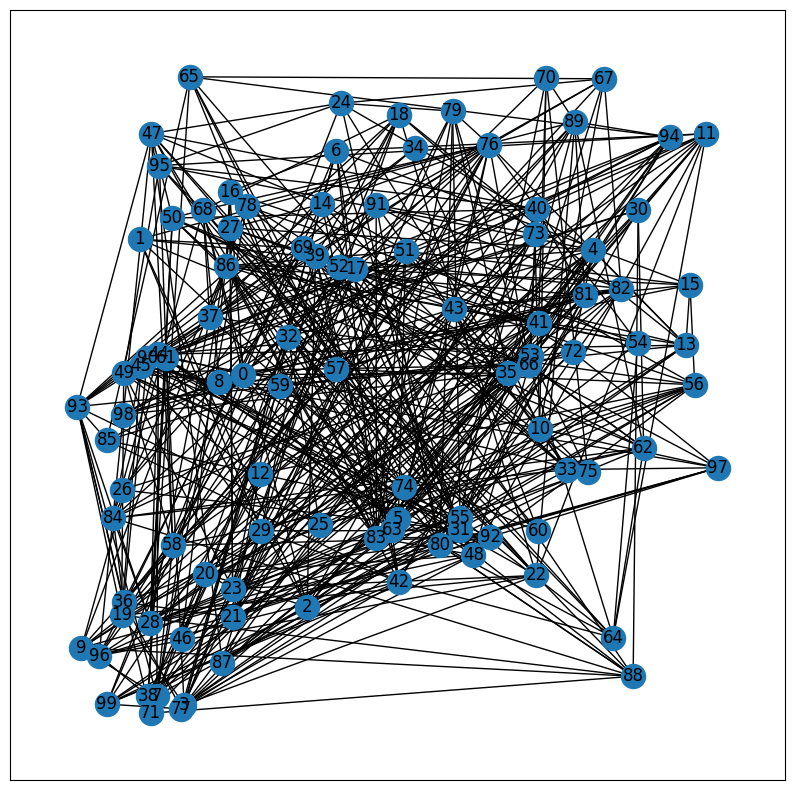

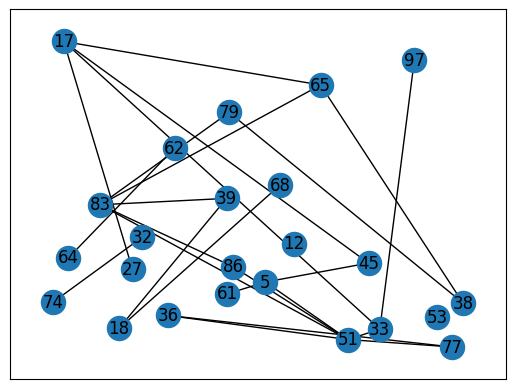

In [976]:
nodes: int = 100
probablity: float = 1.0e-1
sub_graphs: dict[str: int] = {
    Mode.TRAIN: 1,
    Mode.TEST: 0
}
L: dict[str: list[Graph]] = {
    Mode.TRAIN: list[Graph](),
    Mode.TEST: list[Graph]()
}

graph = Graph(nx.gnp_random_graph(nodes, probablity, seed=random_state, directed=False), random_state=random_state)
graph.show((10, 10))
for _ in range(sub_graphs[Mode.TRAIN]):
    sub_graph_nodes: int = random.randint(0, nodes//2) # nodesを制御して, 学習データの数を調整
    sub_graph_nodes_list: list[int] = random.sample(range(nodes), sub_graph_nodes)
    sub_graph: Graph = graph.subgraph(sub_graph_nodes_list)
    sub_graph.show()
    L[Mode.TRAIN].append(sub_graph)

for _ in range(sub_graphs[Mode.TEST]):
    sub_graph_nodes: int = random.randint(0, nodes//2) # nodesを制御して, 学習データの数を調整
    sub_graph_nodes_list: list[int] = random.sample(range(nodes), sub_graph_nodes)
    sub_graph: Graph = Graph(graph.subgraph(sub_graph_nodes_list), random_state=random_state)
    L[Mode.TEST].append(sub_graph)

# Training

In [977]:
def train() -> None:
    pass

In [978]:
train()

# Test

In [979]:
def test() -> None:
    pass

In [980]:
test()